<a href="https://colab.research.google.com/github/johnryantaylor/QCES/blob/main/Project1_numerical_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 1: Diffusion equation

In this project we will use several methods to solve the diffusion equation:

$$ \partial_t c = \kappa \partial_x^2 c $$

This project consists of two notebooks. First, in this notebook, we will solve this equation using second order finite differences to approximate the $x$-derivatives, and we will use both the explict Euler and Crank-Nicolson timestepping methods.

In the second notebook for this project, we will learn how to use Dedalus to solve the same problem using spectral methods.

The objective for this notebook is learn about spatial discretization and to compare the stability, accuracy, and speed of the Explicit euler and Crank-Nicolson methods when applied to the diffusion equation.

Student tasks are in [Section 2.1](#section2pt1) and [Section 2.2](#section2pt2).

Before we start, load in the required libraries

In [1]:
# Importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import time


Now, define two functions to timestep the diffusion equation. The code below timesteps the diffusion equation using the expicit Euler method. The function takes in a vector of discrete positions, `x`, discrete times, `t`, and the diffusivity, `kappa`. The vectors `x` and `t` dictate the discretization of the problem in space and time, and the grid spacing must be constant in space and time. The boundary conditions are $\partial_x c=0$ at the starting and ending points in `x`.

In [2]:
def EE(x, t, kappa):
# This function timesteps the diffusion equation with homogeneous Neumann boundary conditions
# using the explicit Euler and second order finite difference methods

    start_time = time.time()  # Start a timer

    # Infer the uniform grid spacing:
    dx = (x[-1] - x[0]) / (len(x) - 1); dt = (t[-1] - t[0]) / (len(t) - 1)

    # Set the number of gridpoints in x and t
    Nx = len(x); Nt = len(t)

    # Builds a coefficient matrix, such that M*c is the discrete version of d/dx(c)
    M = (np.diag(np.ones(Nx-1), -1) - 2*np.diag(np.ones(Nx), 0) + np.diag(np.ones(Nx-1), 1)) / dx**2

    # Turn M into a sparse matrix to save memory and improve speed
    M = sp.csr_matrix(M)

    # Create an empty sparse array to store the solution
    c = np.zeros((Nx, Nt))

    c[:, 0] = set_ics(x, kappa, 10)  # Set the initial condition

    for k in range(1, Nt):  # loop over the number of timesteps
      c[:,k] = c[:,k-1] + dt * kappa * M @ c[:,k-1]
      # Enforce the boundary conditions (no flux)
      c[0, k] = c[1, k]
      c[-1, k] = c[-2, k]

    end_time = time.time()  # Print the elapsed time

    print(f"Explicit Euler method took {end_time - start_time:.2f} seconds")

    return c

Similarly, the function below timesteps the diffusion equation with the Crank-Nicolson method

In [3]:
def CN(x, t, kappa):
# This function timesteps the diffusion equation with homogeneous Neumann boundary conditions
# using the explicit Euler and second order finite difference methods
    start_time = time.time()  # Start a timer

    # Infer the uniform grid spacing:
    dx = (x[-1] - x[0]) / (len(x) - 1); dt = (t[-1] - t[0]) / (len(t) - 1)

    # Set the number of gridpoints in x and t
    Nx = len(x); Nt = len(t)

    # build a coefficient matrix, such that M*c is the discrete version of d/dx(c)
    M = (np.diag(np.ones(Nx-1), -1) - 2*np.diag(np.ones(Nx), 0) + np.diag(np.ones(Nx-1), 1)) / dx**2

    # Turn M into a sparse matrix to save memory and improve speed:
    M = sp.csr_matrix(M)

    A = sp.eye(Nx) - 0.5 * dt * kappa * M  # This matrix appears on the LHS in the C-N scheme
    A_inv = spla.inv(A) # Calculate the inverse of A (this only needs to be done once)

    # Create an empty sparse array to store the solution
    c = np.zeros((Nx, Nt))

    c[:, 0] = set_ics(x, kappa, 10)  # Set the initial condition

    for k in range(1, Nt): # loop over the number of timesteps
        c[:, k] = A_inv @ (c[:, k-1] + 0.5 * dt * kappa * (M @ c[:, k-1]))
        # Enforce the boundary conditions
        c[0, k] = c[1, k]
        c[-1, k] = c[-2, k]

    end_time = time.time()  # Print the elapsed time

    print(f"Crank-Nicolson method took {end_time - start_time:.2f} seconds")

    return c

Next, create a function to set the initial conditions. The exact solution to the unbounded diffusion equation with a delta function initial condition is:

$$\left(\frac{1}{4\pi\kappa t}\right)^{1/2}e^{-x^2/(4\kappa t)}$$

The function below sets the initial condition by evaluating the exact solution at a given time. Note that it is important that we don't evaluate the exact solution at `t_ic=0` since this will return a delta function which will be undefined on our finite grid. The value of `t_ic` is set within the `EE` and `CN` functions.

In [4]:
# Function to set the initial condition from the exact solution at time t_start
def set_ics(x, kappa, t_ic):
    c_ic = (4*np.pi*kappa*t_ic)**(-0.5)*np.exp(-x**2 / (4*kappa*t_ic))
    # Enforce the boundary conditions
    c_ic[0] = c_ic[1]
    c_ic[-1] = c_ic[-2]
    return c_ic


Finally, define some parameters and the x and t vectors:

In [5]:
# Defining parameters
kappa = 0.001  # diffusivity

# Timestepping parameters
t_start = 0  # start time (note that this is not the same time used to evaluate the exact solution to set the ICs)
t_end = 10  # end time
Nt = 1000  # number of timesteps

# Size of the physical domain
x_start = -1
x_end = 1
Nx = 100

t = np.linspace(t_start, t_end, Nt)  # Create a vector of times
x = np.linspace(x_start, x_end, Nx)  # Create a vector for x

Run each method once:

In [6]:
# Run the simulations
c_EE = EE(x, t, kappa) # explicit Euler
c_CN = CN(x, t, kappa) # Crank-Nicolson

Explicit Euler method took 0.22 seconds
Crank-Nicolson method took 0.21 seconds


/usr/local/lib/python3.10/dist-packages/scipy/sparse/linalg/_dsolve/linsolve.py:603: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/usr/local/lib/python3.10/dist-packages/scipy/sparse/linalg/_matfuncs.py:76: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  Ainv = spsolve(A, I)


and finally, plot the results side-by-side

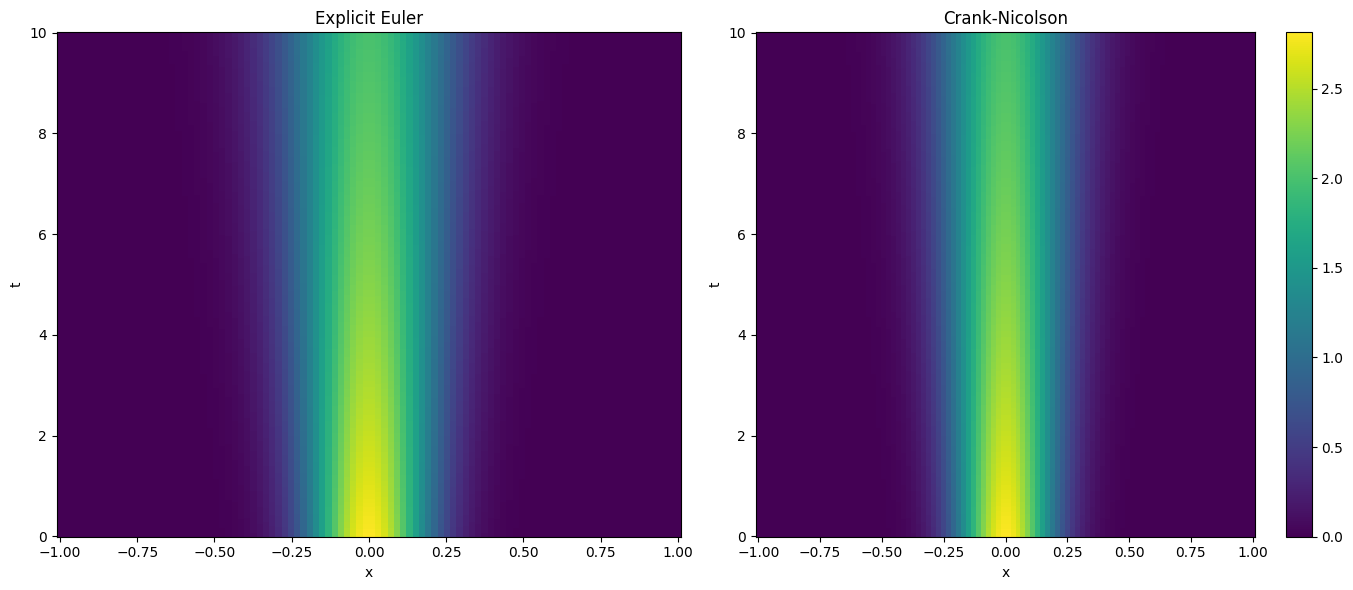

In [7]:
# Plot the results
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.pcolormesh(x, t, c_EE.T, shading='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Explicit Euler')

plt.subplot(1, 2, 2)
plt.pcolormesh(x, t, c_CN.T, shading='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Crank-Nicolson')

plt.colorbar()

plt.tight_layout()
plt.show()



## 2. Student investigation

### 2.1 Stability
<a id='section2pt1'></a>
The explicit Euler and Crank-Nicolson methods have very different stability properties. To explore this, try increasing the timestep (reduce the number of timesteps) and/or increase the diffusivity ($\kappa$) and see how each method responds. How does the stability depend on `Nx`? Discuss your findings below (~1 paragraph)

**My answer**

Currently we have 1000 timesteps.
- If we change this to nt = 100: Honestly cant see any difference, still looks smooth
- If we change this to nt = 10: we see artifact 'squares' produces but net process very similar

Currently we have nx = 100.
- if we change this to nx = 10: the plots turn into 10 separate columns, very low resolution
- if we change this to nx = 50: we see 50 bars

-> nx dictates horizontal resolution heavily, while nt will still allow things to work at low numbers

-> all these are stable responses

To see what happens in an unstable response we increase kappa to 0.1. The Explicit Euler method collapses while the Crank-Nicholson method remains stable.
- kappa = 0.001 - both stable
- kappa = 0.01 - both stable but appears low resolution
- kappa = 0.08 - both stable
- kappa = 0.1 - euler unstable
- kappa = 1 - crank-nicholson still stable

The semi-implicit method is far more stable that explicit. Crank-nicholson only breaks down later due to boundary condition issues. The flux at the boundary does not match the solution at the interior.


### 2.2 Accuracy
<a id='section2pt2'></a>
Next, we will examine the accuracy of the numerical methods used above. In order to do this, it is useful to compare our numerical solutions with the exact solution to the diffusion equation. Below, write code to plot the exact solution and the numerical solution using explicit Euler and Crank-Nicolson at the final time ($t=10$). Note that you can use the exact solution to the diffusion equation in an unbounded domain in $x$ and keep in mind that the exact solution and numerical solutions will differ for later times when boundary effects are felt.

In [8]:
def conc(x, t, kappa):
    # This function timesteps the diffusion equation with homogeneous Neumann boundary conditions
    # using the explicit Euler and second order finite difference methods
    X, T = np.meshgrid(x, t)

    return  (4*np.pi*kappa*T)**(-0.5)*np.exp(-1*np.square(X) / (4*kappa*T))

conc(x, t, kappa)

<ipython-input-8-e12717af3775>:6: RuntimeWarning: divide by zero encountered in power
  return  (4*np.pi*kappa*T)**(-0.5)*np.exp(-1*np.square(X) / (4*kappa*T))
<ipython-input-8-e12717af3775>:6: RuntimeWarning: divide by zero encountered in divide
  return  (4*np.pi*kappa*T)**(-0.5)*np.exp(-1*np.square(X) / (4*kappa*T))
<ipython-input-8-e12717af3775>:6: RuntimeWarning: invalid value encountered in multiply
  return  (4*np.pi*kappa*T)**(-0.5)*np.exp(-1*np.square(X) / (4*kappa*T))


array([[           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [3.72982213e-11, 1.01580280e-10, 2.71050781e-10, ...,
        2.71050781e-10, 1.01580280e-10, 3.72982213e-11],
       [3.82271018e-11, 1.04005586e-10, 2.77249536e-10, ...,
        2.77249536e-10, 1.04005586e-10, 3.82271018e-11],
       [3.91771663e-11, 1.06483714e-10, 2.83577072e-10, ...,
        2.83577072e-10, 1.06483714e-10, 3.91771663e-11]])

In [9]:
c_conc = conc(x, t, kappa)

<ipython-input-8-e12717af3775>:6: RuntimeWarning: divide by zero encountered in power
  return  (4*np.pi*kappa*T)**(-0.5)*np.exp(-1*np.square(X) / (4*kappa*T))
<ipython-input-8-e12717af3775>:6: RuntimeWarning: divide by zero encountered in divide
  return  (4*np.pi*kappa*T)**(-0.5)*np.exp(-1*np.square(X) / (4*kappa*T))
<ipython-input-8-e12717af3775>:6: RuntimeWarning: invalid value encountered in multiply
  return  (4*np.pi*kappa*T)**(-0.5)*np.exp(-1*np.square(X) / (4*kappa*T))


(1000, 100) (100,) (1000,)


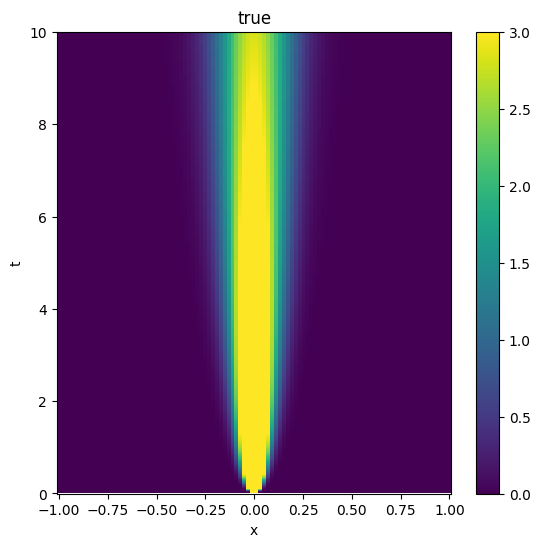

In [10]:
plt.figure(figsize=(14, 6))
print(c_conc.shape, x.shape, t.shape)
plt.subplot(1, 2, 1)
plt.pcolormesh(x, t, c_conc)
plt.xlabel('x')
plt.ylabel('t')
plt.title('true')
plt.colorbar()
plt.clim(0,3)

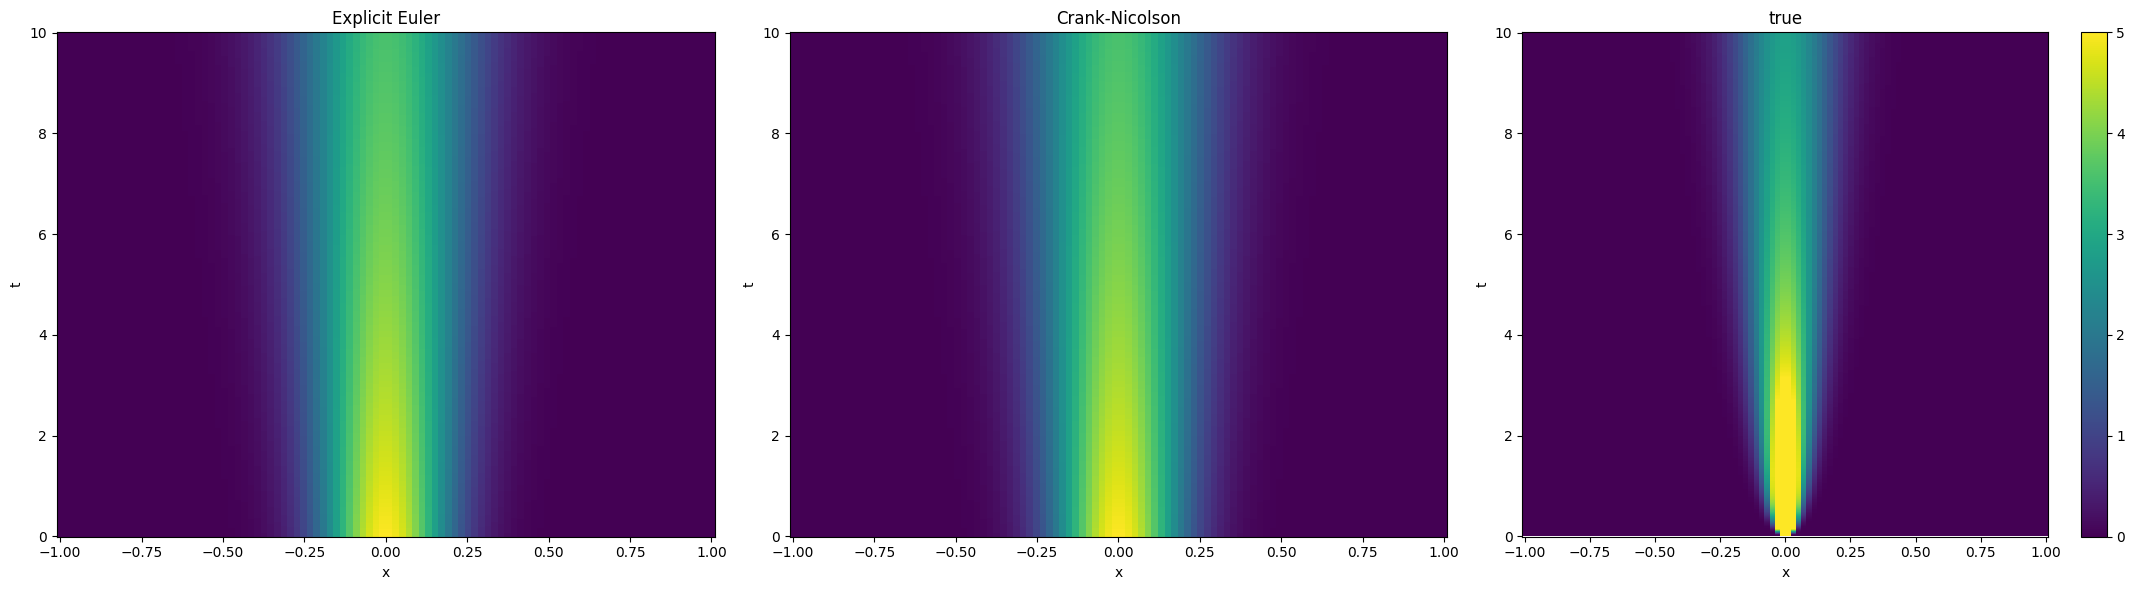

In [11]:
plt.figure(figsize=(22, 6))

plt.subplot(1, 3, 1)
plt.pcolormesh(x, t, c_EE.T, shading='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Explicit Euler')

plt.subplot(1, 3, 2)
plt.pcolormesh(x, t, c_CN.T, shading='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Crank-Nicolson')

plt.subplot(1, 3, 3)
plt.pcolormesh(x, t, c_conc)
plt.xlabel('x')
plt.ylabel('t')
plt.title('true')
plt.colorbar()
plt.clim(0,5)


plt.tight_layout()
plt.show()

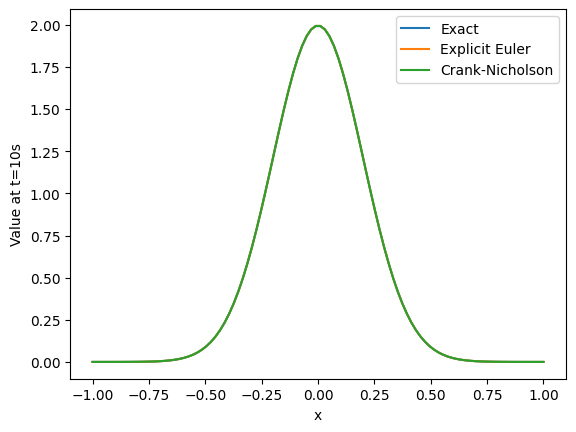

In [15]:
# c_EE.T.shape, x.shape, t.shape

def oneD_conc(x, t, kappa):
    return  (4*np.pi*kappa*t)**(-0.5)*np.exp(-1*np.square(x) / (4*kappa*t))

# t is 20 for the exact equation
# Here, time runs from 0 to 20
# in the models, t is 10 - this is because they start at the 'centre'
# one side moves in the positive direction (10 to 20) while the other moves from 10 to 0.

exact_value = oneD_conc(x, 20, kappa)

plt.plot(x, exact_value, label = 'Exact')
plt.plot(x, c_EE[:,-1], label = 'Explicit Euler')
plt.plot(x, c_CN[:,-1], label = 'Crank-Nicholson')
plt.legend()
plt.xlabel('x')
plt.ylabel('Value at t=10s')
plt.show()

Now, define a measure of the error of each numerical method compared to the exact solution (there is no single correct way to do this). Plot the error of both methods as a function of the grid spacing $\Delta x$. Then, similarly plot the error as a function of the timestep, $\Delta t$.

*Definition of error*

There are multiple potential ways to define error in this. A convenient method, however, is to look at the absolute difference between model and true solution for each value of x (still at t=10s, though).

This is shown in the graph below. Absolute error is calculated for all x values.

It should be noted that error undulates depending on x - error varies through the function. We see error peaks at (apprximately) x=0, x=+/-0.3, and x=+/-0.6.
We see lowest error at

Text(0.5, 1.0, 'Error relative to the exact solution')

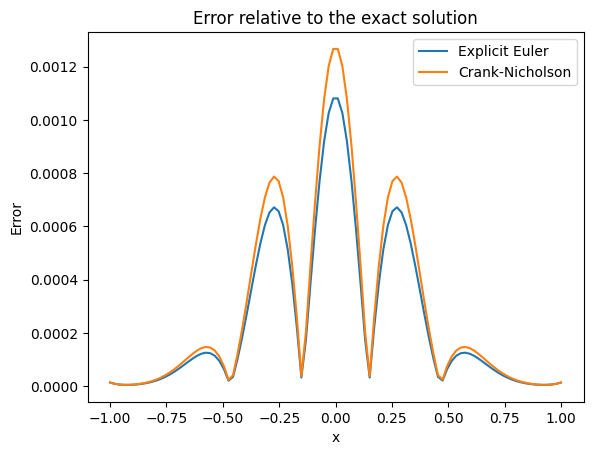

In [20]:
# Again, t = 20 for the true solution is equivalent to t = 10 for the models

def euler_error(x):
  error_ee = abs(c_EE[:,-1] - oneD_conc(x, 20, kappa))
  return error_ee

def CN_error(x):
  error_CN = abs(c_CN[:,-1] - oneD_conc(x, 20, kappa))
  return error_CN


plt.plot(x, euler_error(x), label = 'Explicit Euler')
plt.plot(x, CN_error(x), label = 'Crank-Nicholson')
plt.legend()
plt.xlabel('x')
plt.ylabel('Error')
plt.title('Error relative to the exact solution')

Finally, select a given error tolerance and explore whether explicit Euler or Crank-Nicoslon is more efficient (faster) at generating solutions with error less than your error tolerance. Discuss your conclusion and add supporting figures if necessary.

INSERT DISCUSSION OF ERROR HERE (~1 paragraph).  OPTIONALLY ADD PLOTS BY INSERTING A CODE BLOCK BELOW.

Now, move to Project1_dedalus.ipynb which will introduce Dedalus and spectral methods.

### 3. Optional further investigations

The application of the boundary conditions for the Crank-Nicolson method isn't quite right in the script above (but the boundary conditions aren't very important in this example). Account for the boundary conditions by modifying the coefficient matrix. This ensures that the boundary conditions are applied to the implicit and explicit terms involved in the Crank-Nicolson update. How would you handle fixed value (Dirichlet) and fixed gradient (Neumann) boundary conditions?